## Malicious URLs

Dataset Source: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

#### Install Necessary Libraries

In [1]:
%pip install torch transformers datasets evaluate
%pip install --upgrade accelerate
%pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.1 MB/s eta 0:00:00


#### HuggingFace Login Via Command Line

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Traceback (most recent call last):
  File "/usr/local/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/huggingface_cli.py", line 45, in main
    service.run()
  File "/usr/local/lib/pyth

#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, set_seed, AutoTokenizer
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

import peft
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptEncoderConfig)

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Display Library Versions

In [4]:
print("Python :".rjust(15), sys.version[0:6])
print("NumPy :".rjust(15), np.__version__)
print("Pandas :".rjust(15), pd.__version__)
print("Datasets :".rjust(15), datasets.__version__)
print("Transformers :".rjust(15), transformers.__version__)
print("Torch :".rjust(15), torch.__version__)
print("Evaluate :".rjust(15), evaluate.__version__)
print("PEFT :".rjust(15), peft.__version__)

       Python : 3.10.1
        NumPy : 1.22.4
       Pandas : 1.5.3
     Datasets : 2.13.1
 Transformers : 4.30.2
        Torch : 2.0.1+cu118
     Evaluate : 0.4.0
         PEFT : 0.4.0


#### Mount Google Drive to Notebook

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load & Start Preprocessing Dataset

In [6]:
names = ["text",
         "label"]

data_types = {
    "text": str,
    "label": str,
    }

data = pd.read_csv("/content/drive/MyDrive/projects/malicious URLs/malicious_phish.csv",
                   names=names,
                   dtype=data_types,
                   header=0)

data['text'] = data['text'].drop_duplicates().reset_index(drop=True)

data['label'] = data['label'].apply(lambda x: x.strip())

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641119 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    641119 non-null  object
 1   label   641119 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [7]:
unique_labels = data['label'].unique()

id2label = {idx:label for idx, label in enumerate(unique_labels)}
label2id = {label:idx for idx, label in enumerate(unique_labels)}

NUM_OF_LABELS = len(unique_labels)

print(unique_labels)
print(NUM_OF_LABELS)
print(label2id)
print(id2label)

['phishing' 'benign' 'defacement' 'malware']
4
{'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}
{0: 'phishing', 1: 'benign', 2: 'defacement', 3: 'malware'}


#### Visual: Histogram of Text Lengths

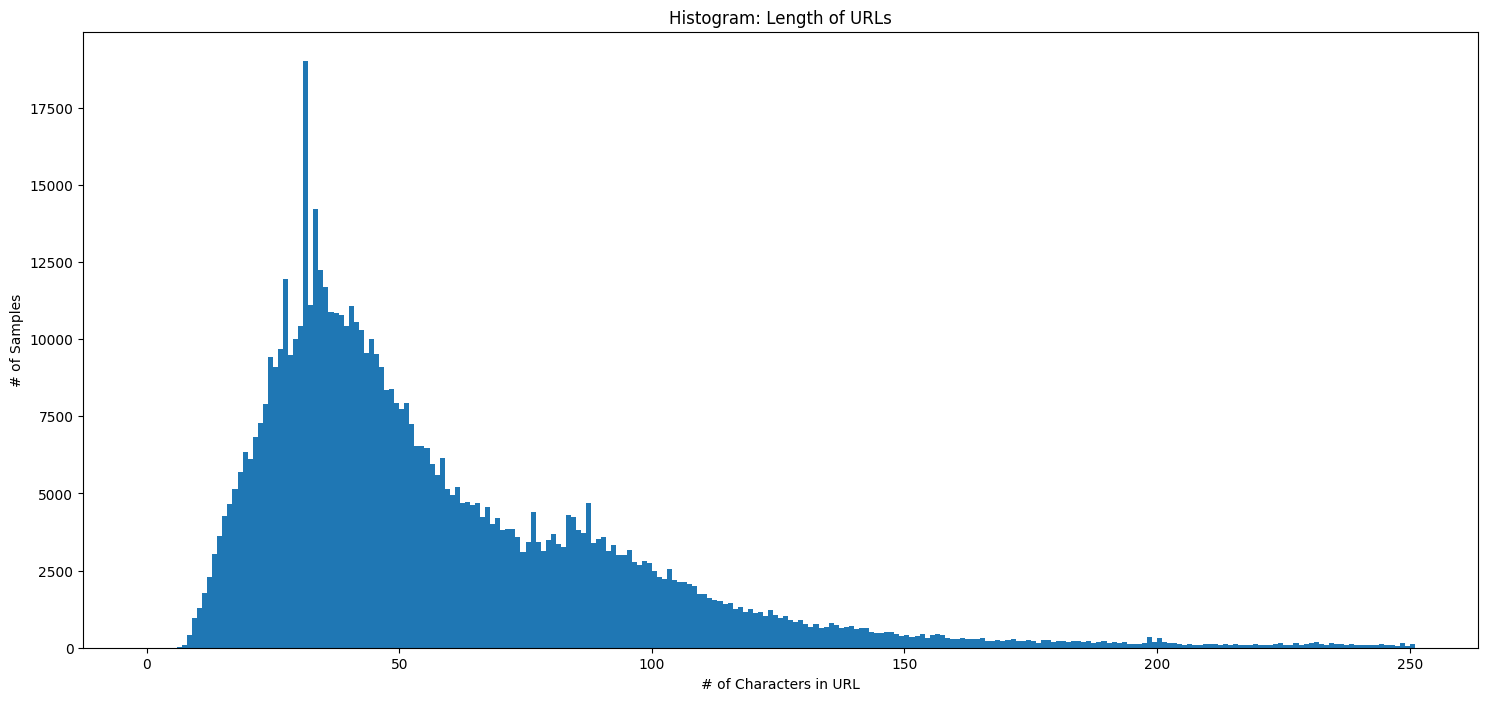

The maximum length of the URLs is 2175 characters.


In [8]:
data['text_length'] = data['text'].str.len()

n_bin=250
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin + 1), bins=(n_bin + 1))
plt.title('Histogram: Length of URLs')
plt.xlabel('# of Characters in URL')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the URLs is {max(data['text_length'])} characters.")

#### Visual: Tweet Length by Class

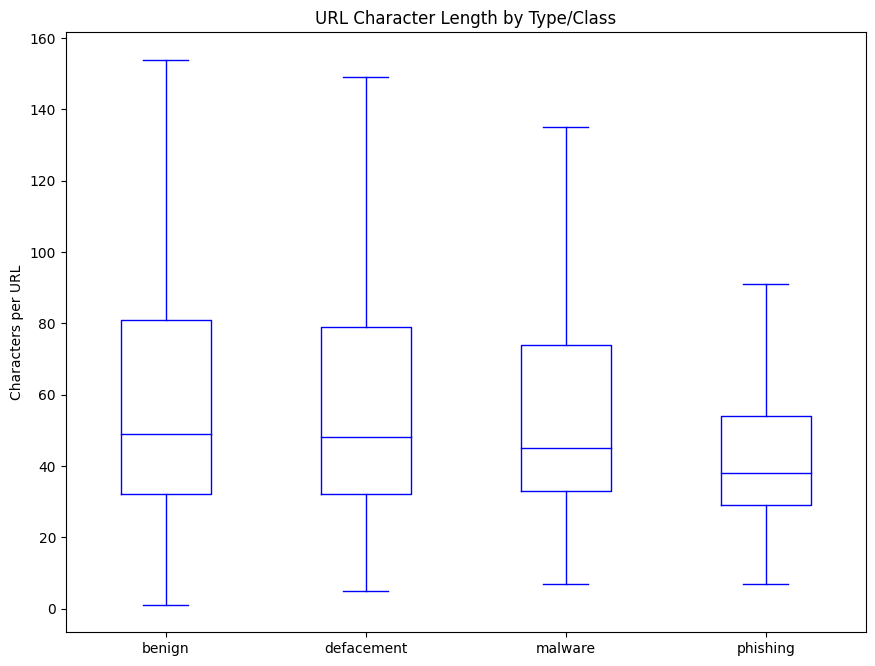

In [9]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,8))

plt.suptitle('')
plt.title('URL Character Length by Type/Class')
plt.xlabel('')
plt.ylabel('Characters per URL')
plt.show()

#### Final Data Preprocessing

In [10]:
data = data[data['text_length'] < 161]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622030 entries, 0 to 641118
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    622030 non-null  object
 1   label   622030 non-null  object
dtypes: object(2)
memory usage: 14.2+ MB


#### Barplot Function

In [11]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   show_class_amounts: bool = True
                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(8, 6),
                                                      rot=0,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red"]
                                                      )

    if show_class_amounts:
        ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Number of Samples in Each Class

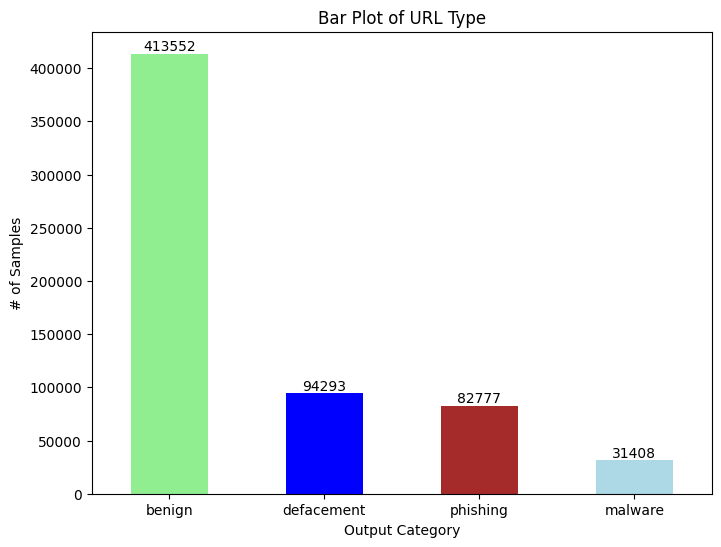

In [12]:
barplot_visual(data["label"],
               "Bar Plot of URL Type",
               "Output Category",
               "# of Samples",
               )

#### Convert Label Values From String to Integer

In [13]:
data['label'] = data['label'].replace(label2id).astype(np.int8)

#### Convert DataFrame to Dataset

In [14]:
dataset = Dataset.from_pandas(data)

#### Split Dataset into Training Evaluation Datasets

In [15]:
train_testeval = dataset.train_test_split(train_size=0.70)
test_eval = train_testeval['test'].train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_testeval['train'],
    'test' : test_eval['test'],
    'eval' : test_eval['train']
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (435421, 3)
Testing Dataset Shape: (37322, 3)
Evaluation Dataset Shape: (149287, 3)


#### Find Longest Tokenized Input Value

In [16]:
"""MODEL_CKPT = "roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,
                                          truncation=True,
                                          padding=True,
                                          batched=True,
                                          batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in dataset["text"]]

print(f"The longest article length is {max(text_len)} tokens.")"""

'MODEL_CKPT = "roberta-large"\n\ntokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,\n                                          truncation=True,\n                                          padding=True,\n                                          batched=True,\n                                          batch_size=None)\n\ntext_len = [len(tokenizer.encode(a)) for a in dataset["text"]]\n\nprint(f"The longest article length is {max(text_len)} tokens.")'

#### Basic Values/Constants

In [40]:
set_seed = 42
NUM_OF_EPOCHS = 2

BATCH_SIZE = 64
LEARNING_RATE = 1e-3

MODEL_CKPT = "roberta-large"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Malicious_URLs-PEFT"

MAX_LENGTH = 206 #max(text_len)
DEVICE = torch.device("cuda")

METRIC_NAME = "f1"

print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will have a maximum length for the input text of 206 tokens.
The model checkpoint used for this project is: roberta-large


#### Define Function to Display Parameter Information

In [18]:
# Define Helper Function to Check Total Number of Model Parameters
# Also, return Number of Trainable Parameters

def print_parameters_information(model):
    trainable_parameters = 0
    all_parameters = 0

    for _, parameters in model.named_parameters():
        all_parameters += parameters.numel()
        if parameters.requires_grad:
            trainable_parameters += parameters.numel()

    print(f'Trainable Parameters: {trainable_parameters} ' + \
          f'|| All Parameters: {all_parameters} ' + \
          f'|| Trainable %: {round(trainable_parameters / all_parameters * 100, 2)}')

#### Tokenize Entire Dataset

In [41]:
if any(k in MODEL_CKPT for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,
                                          padding_side=padding_side)

if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Define Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'],
                     truncation=True,
                     max_length=None)

# Tokenize entire dataset
encoded_data = ds.map(tokenize,
                      batched=True,
                      remove_columns=["text"]
                      )

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/435421 [00:00<?, ? examples/s]

Map:   0%|          | 0/37322 [00:00<?, ? examples/s]

Map:   0%|          | 0/149287 [00:00<?, ? examples/s]

Training data shape: (435421, 4)
Validation data shape: (149287, 4)
{'label': Value(dtype='int8', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 435421
})


#### Define Prompt Encoder Configuration

In [42]:
p_tuning_config = PromptEncoderConfig(task_type="SEQ_CLS",
                                  num_virtual_tokens=20,
                                  encoder_hidden_size=128
                                  )

#### Instantiate Model

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    )

#### Apply P-Tuning Configuration to Model

In [44]:
model = get_peft_model(model,
                       p_tuning_config)

print_parameters_information(model)

Trainable Parameters: 2407688 || All Parameters: 356717832 || Trainable %: 0.67


/usr/local/lib/python3.10/dist-packages/peft/tuners/p_tuning.py:146: UserWarning: for MLP, the `encoder_num_layers` is ignored. Exactly 2 MLP layers are used.
  warnings.warn(


#### Define Function to Compute Metrics

In [45]:
def compute_metrics(p):
    """
    This function takes the predictions output from
    trainer.evaluate & returns metrics (accuracy, F1,
    recall, & precision) for a multiclass
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions,
                                                             axis=1),
                                       references=p.label_ids)['accuracy']

    ### ------------------- F1 scores -------------------

    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                      axis=1),
                                                references=p.label_ids,
                                                average='weighted')["f1"]

    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='micro')['f1']

    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions,
                                                                   axis=1),
                                             references=p.label_ids,
                                             average='macro')["f1"]

    ### ------------------- recall -------------------

    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                                  axis=1),
                                            references=p.label_ids,
                                            average='weighted')["recall"]

    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='micro')["recall"]

    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1),
                                         references=p.label_ids,
                                         average='macro')["recall"]

    ### ------------------- precision -------------------

    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                        axis=1),
                                                  references=p.label_ids,
                                                  average='weighted')["precision"]

    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='micro')["precision"]

    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions,
                                                                     axis=1),
                                               references=p.label_ids,
                                               average='macro')["precision"]

    return {"accuracy" : accuracy,
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [46]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    auto_find_batch_size=True,
    weight_decay=0.01,
    use_mps_device=False,
    log_level="error",
    logging_strategy='steps',
    logging_steps=200,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    group_by_length=True,
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    fp16=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [47]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        padding="longest")

#### Subclass Trainer to Handle Class Imbalance

In [48]:
class CustomTrainer(Trainer):
    def compute_loss(self,
                     model,
                     inputs,
                     return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(
            [
                1.0, 2.0, 3.0, 4.0
              ],
            device=DEVICE
            )
        )
        loss = loss_fct(logits.view(-1,
                                    self.model.config.num_labels
                                    ),
                        labels.view(-1)
                        )
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [50]:
trainer = CustomTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'],
                  eval_dataset=encoded_data['test'],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

/content/roberta-large-Malicious_URLs-PEFT is already a clone of https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [51]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.979000,0.918090,0.699105,0.612587,0.699105,0.395607,0.699105,0.699105,0.384975,0.588486,0.699105,0.487770


Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.979000,0.918090,0.699105,0.612587,0.699105,0.395607,0.699105,0.699105,0.384975,0.588486,0.699105,0.487770
2,0.883800,0.855216,0.715985,0.636198,0.715985,0.437383,0.715985,0.715985,0.419031,0.608680,0.715985,0.523734


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Save Model & Metrics on Training Dataset

In [52]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Upload file adapter_model.bin:   1%|          | 32.0k/4.10M [00:00<?, ?B/s]

Upload file runs/Jul18_17-17-58_51826846a56d/events.out.tfevents.1689700715.51826846a56d.234.1:  35%|###5     …

To https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT
   853c1d8..eb80919  main -> main

   853c1d8..eb80919  main -> main

To https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT
   eb80919..82825eb  main -> main

   eb80919..82825eb  main -> main



***** train metrics *****
  epoch                    =        2.0
  total_flos               = 39225471GF
  train_loss               =     0.9731
  train_runtime            = 2:47:26.38
  train_samples_per_second =     86.682
  train_steps_per_second   =     10.835


#### Save Evaluation Dataset to Use In Separate Notebook

In [53]:
where_to_save_eval_ds = "/content/drive/MyDrive/projects/malicious URLs/eval_dataset.csv"

ds['eval'].to_csv(where_to_save_eval_ds)

Creating CSV from Arrow format:   0%|          | 0/150 [00:00<?, ?ba/s]

9614095

#### Push Model to HuggingFace Hub

In [54]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT
   82825eb..6410c38  main -> main

   82825eb..6410c38  main -> main

To https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT
   6410c38..6554b46  main -> main

   6410c38..6554b46  main -> main



'https://huggingface.co/DunnBC22/roberta-large-Malicious_URLs-PEFT/commit/6410c38195be2b6bc30c04fef888c99d53920ba2'

### Notes & Other Takeaways From This Project

****
-

****

### Citations
- Model Checkpoint
    
    > @article{DBLP:journals/corr/abs-1907-11692, author = {Yinhan Liu and Myle Ott and Naman Goyal and Jingfei Du and Mandar Joshi and Danqi Chen and Omer Levy and Mike Lewis and Luke Zettlemoyer and Veselin Stoyanov}, title = {RoBERTa: {A} Robustly Optimized {BERT} Pretraining Approach}, journal = {CoRR}, volume = {abs/1907.11692}, year = {2019}, url = {http://arxiv.org/abs/1907.11692}, archivePrefix = {arXiv}, eprint = {1907.11692}, timestamp = {Thu, 01 Aug 2019 08:59:33 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-1907-11692.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Optimizer (PEFT)
   > @Misc{peft, title = {PEFT: State-of-the-art Parameter-Efficient Fine-Tuning methods}, author = {Sourab Mangrulkar and Sylvain Gugger and Lysandre Debut and Younes Belkada and Sayak Paul}, howpublished = {\url{https://github.com/huggingface/peft}}, year = {2022}}